<h2 style="color: darkslategray">Project for "WikiShop" with BERT<a class="tocSkip"></a></h2>

The online store "WikiShop" is launching a new service. Now users can edit and enhance product descriptions, similar to wiki communities. This means that customers can suggest their edits and comment on other changes. The store needs a tool that will detect toxic comments and send them for moderation.

**Project Objective:** To train a model to classify comments as positive or negative. We have a dataset with labels indicating the toxicity of the edits.

**The goal** is to build a model with an F1 quality metric of at least 0.75.

**Project Process**

The research will be conducted in 4 stages:

- 1. Data preparation.
- 2. Model training.
- 3. Model testing.
- 4. Overall conclusion.

**Data Description**

The data is contained in the file `toxic_comments.csv`. The column *text* contains the comment text, and *toxic* represents the target feature.

The problem can be solved both with and without the use of the **BERT** neural network. We will try both approaches.

<img src="https://img.freepik.com/free-vector/customer-feedback-concept-illustration_114360-7038.jpg" width="600" height="600" alt="Bar Chart" />

## Data Preparation

Let's load the necessary libraries and open the data file.

In [1]:
# Library imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer 

import re
import torch
from torch.utils.data import Dataset, DataLoader
import transformers

plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)
%env PYTHONWARNINGS = ignore

RANDOM_STATE = 12345

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

lemmatizer = WordNetLemmatizer()
stopwords = nltk_stopwords.words('english')

env: PYTHONWARNINGS=ignore


In [2]:
# File import

df_comments = pd.read_csv("./toxic_comments.csv")

Now we will proceed to exploring the available data.

In [3]:
# Displaying the first 5 rows of the table

df_comments.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


Removing the redundant column that duplicates the indices.

In [4]:
# Column removal

df_comments = df_comments.drop(df_comments.columns[0], axis=1)

In [5]:
# Displaying general information about the dataframe

df_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


The dataset contains 2 features and 159,292 observations. There are no missing values. Let's examine the class distribution in the target feature.

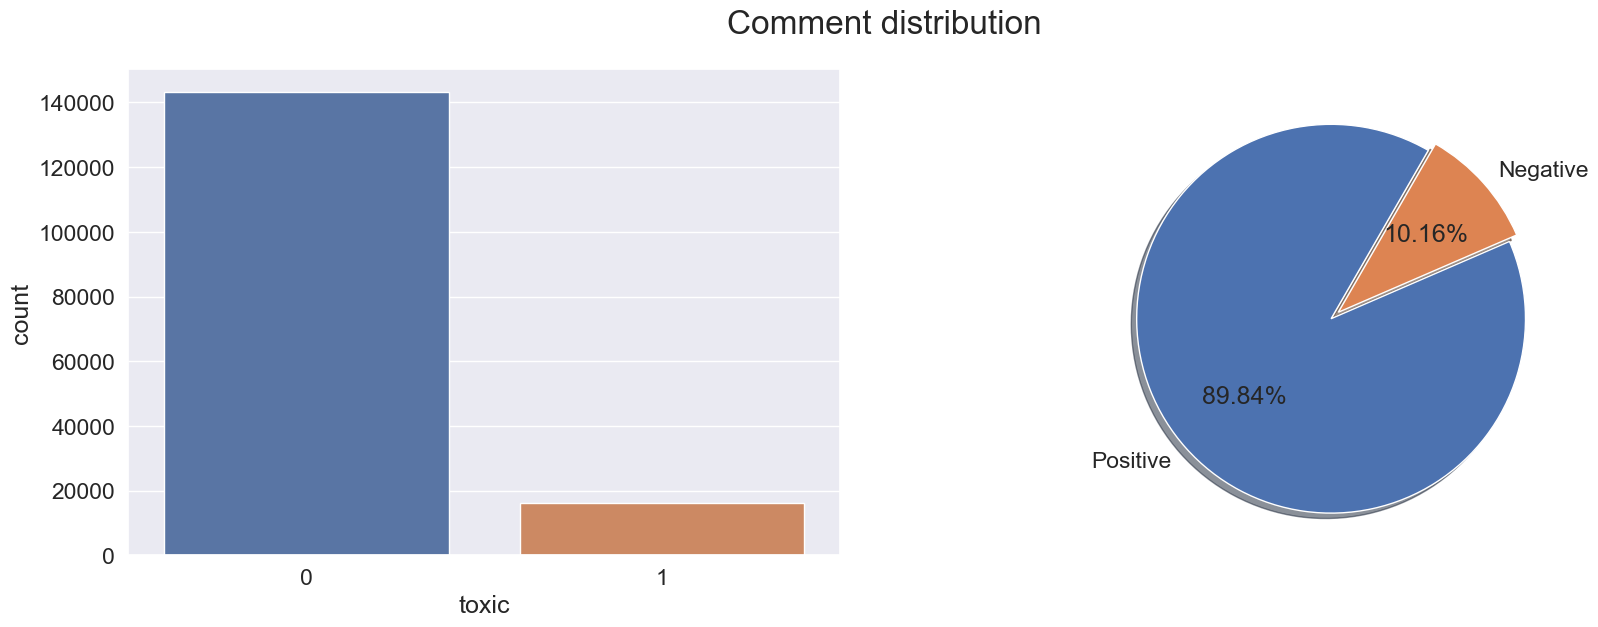

In [6]:
# Displaying the target feature

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), dpi=100)
sns.countplot(data=df_comments, ax=axes[0], x='toxic')
axes[1].pie(df_comments['toxic'].value_counts(),
            labels=['Positive', 'Negative'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Comment distribution', fontsize=24)
plt.show()

There is a class imbalance in the dataset: 90% positive comments and 10% toxic comments.

# Solving the Problem without BERT

Before moving on to word vector representation, I will preprocess the text. Firstly, I will tokenize each comment, lemmatize the words, and clean the text by removing unnecessary symbols. I will write a corresponding function to perform these actions.

In [7]:
def lemmatize_text(text):
    tokens = nltk.word_tokenize(text)
    joined = ' '.join(tokens)
    regular = re.sub(r'[^a-zA-Z]', ' ', joined)
    final_text = ' '.join(regular.split())
    return final_text

Let's display the first line of the original text for comparison:

In [8]:
print("Original text:", df_comments['text'][0])

Original text: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


I will apply the function to the data:

In [9]:
from tqdm import tqdm
tqdm.pandas()
df_comments['text'] = df_comments['text'].progress_apply(lemmatize_text) 

100%|███████████████████████████████████████████████████████████| 159292/159292 [00:31<00:00, 5040.86it/s]


Let's display the first line of the transformed text:

In [10]:
print("Cleaned and lemmatized text:", df_comments['text'][0])

Cleaned and lemmatized text: Explanation Why the edits made under my username Hardcore Metallica Fan were reverted They were n t vandalisms just closure on some GAs after I voted at New York Dolls FAC And please do n t remove the template from the talk page since I m retired now


The data has been preprocessed successfully.

To enable algorithms to determine the topic and sentiment of the text, they need to be trained on a corpus. Therefore, I will save the corpus as a feature variable.

In [11]:
features_nltk = df_comments['text']

Next, I will split the dataset into training and testing sets. When splitting, I will use the stratify argument to maintain the initial class distribution in the new datasets (since we previously observed a class imbalance).

In [12]:
train_features_nltk, test_features_nltk, train_target_nltk, test_target_nltk = train_test_split(features_nltk, \
                                                        df_comments['toxic'], test_size=0.2, \
                                                        random_state=RANDOM_STATE, stratify=df_comments['toxic'])
print(f"Number of instances per class in the target feature for the training set: {np.bincount(train_target_nltk)}")
print(f"Number of instances per class in the target feature for the testing set: {np.bincount(test_target_nltk)}")

Number of instances per class in the target feature for the training set: [114484  12949]
Number of instances per class in the target feature for the testing set: [28622  3237]


We obtained two datasets with 80% and 20% of the original dataset, respectively, while preserving the initial class distribution - 90% of examples belong to class 0, and 10% belong to class 1.

The data is ready, and we can proceed to the model training stage.

## Model Training

For this classification task I will use the `LogisticRegression`, `RandomForestClassifier` and `CatBoostClassifier` models. To account for the class imbalance, I will set the **`class_weight`** attribute for automatic class weight adjustment. I will use the `RandomizedSearchCV` class to search for optimal parameter values. I will employ a Pipeline, where the first step will include a vectorizer and text cleaning by removing stop words.

### LogisticRegression

In [13]:
pipeline_logreg = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('logreg', LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced'))
])
parameters_logreg = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'logreg__C': [0.01, 0.1, 1, 10],
    'logreg__max_iter': [10, 100, 1000]
}

grid_search_logreg = RandomizedSearchCV(pipeline_logreg, parameters_logreg, cv=3, n_jobs=-1, \
                                        scoring='f1', verbose=3)
grid_search_logreg.fit(train_features_nltk, train_target_nltk)

print(grid_search_logreg.best_score_)

0.7782241406706246


### RandomForestClassifier

In [14]:
pipeline_forest = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('randomforest', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
])
parameters_forest = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'randomforest__max_depth': [2, 8, 15],
    'randomforest__n_estimators': [10, 50, 100]
}

grid_search_forest = RandomizedSearchCV(pipeline_forest, parameters_forest, cv=3, n_jobs=-1, \
                                        scoring='f1', verbose=3)
grid_search_forest.fit(train_features_nltk, train_target_nltk)

print(grid_search_forest.best_score_)

0.37340155774831213


### CatBoostClassifier

For the CatBoostClassifier model I will create a `class_weights` dictionary with classes and corresponding weights calculated considering the class imbalance and pass it to the model as a parameter.

In [15]:
classes = np.unique(train_target_nltk)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_target_nltk)
class_weights = dict(zip(classes, weights))

print(class_weights)

{0: 0.5565537542363999, 1: 4.9205730172214075}


In [16]:
pipeline_cbc = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('catboost', CatBoostClassifier(random_state=RANDOM_STATE, class_weights=class_weights))
])
parameters_cbc = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'catboost__learning_rate': [0.01, 0.1, 0.5],
    'catboost__depth': [3, 5, 7, 9],
    'catboost__iterations': [50, 100]
}

grid_search_cbc = RandomizedSearchCV(pipeline_cbc, parameters_cbc, cv=3, n_jobs=-1, \
                                        scoring='f1', verbose=3)
grid_search_cbc.fit(train_features_nltk, train_target_nltk)

print(grid_search_cbc.best_score_)

0.708596559241197


Let's summarize the results for three models we've built.

In [17]:
# Passing the feature values to the DataFrame constructor()

results = pd.DataFrame(
    {'Prediction Quality (F1 Score)' : [grid_search_logreg.best_score_, grid_search_forest.best_score_, grid_search_cbc.best_score_]})

# Setting column names to the indices

results.index = ['LogisticRegression', 'RandomForestClassifier', 'CatBoostClassifier']

# Displaying the table

display(results)

,Prediction Quality (F1 Score)
LogisticRegression,0.778224
RandomForestClassifier,0.373402
CatBoostClassifier,0.708596


Based on the results obtained, we can conclude that the best model for classifying comments as positive or negative is LogisticRegression (with an F1 score of 0.778, which meets the project's requirements).

## Model Testing

Evaluating the quality of the logistic regression model on the test set.

In [18]:
estimator = grid_search_logreg.best_estimator_

estimator.fit(train_features_nltk, train_target_nltk)
predicted_nltk = estimator.predict(test_features_nltk)

print('F1 score for logistic regression on the test set:', f1_score(test_target_nltk, predicted_nltk))

F1 score for logistic regression on the test set: 0.7934436181514646


### BERT Solution

The data has already been cleaned and lemmatized in the previous stage. Before converting the texts into vectors, we need to prepare them. First, I will initialize the tokenizer.

In [19]:
tokenizer = transformers.BertTokenizer.from_pretrained("unitary/toxic-bert")

Let's see how the tokenizer works on the first row of the dataset.

In [20]:
# Displaying the original comment

print('Original: ', df_comments['text'][0])

# Displaying the tokenized version of the string

print('Tokenized: ', tokenizer.tokenize(df_comments['text'][0]))

# Displaying the sentence mapped to token IDs

print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(df_comments['text'][0])))

Original:  Explanation Why the edits made under my username Hardcore Metallica Fan were reverted They were n t vandalisms just closure on some GAs after I voted at New York Dolls FAC And please do n t remove the template from the talk page since I m retired now
Tokenized:  ['explanation', 'why', 'the', 'edit', '##s', 'made', 'under', 'my', 'user', '##name', 'hardcore', 'metallic', '##a', 'fan', 'were', 'reverted', 'they', 'were', 'n', 't', 'van', '##dal', '##isms', 'just', 'closure', 'on', 'some', 'gas', 'after', 'i', 'voted', 'at', 'new', 'york', 'dolls', 'fa', '##c', 'and', 'please', 'do', 'n', 't', 'remove', 'the', 'template', 'from', 'the', 'talk', 'page', 'since', 'i', 'm', 'retired', 'now']
Token IDs:  [7526, 2339, 1996, 10086, 2015, 2081, 2104, 2026, 5310, 18442, 13076, 12392, 2050, 5470, 2020, 16407, 2027, 2020, 1050, 1056, 3158, 9305, 22556, 2074, 8503, 2006, 2070, 3806, 2044, 1045, 5444, 2012, 2047, 2259, 14421, 6904, 2278, 1998, 3531, 2079, 1050, 1056, 6366, 1996, 23561, 201

To make the BERT model work, we need to convert the text into tokens. First, I will find the maximum token chain length for the majority of rows in our dataset. I will tokenize them and set 512 as the maximum length for the tokenizer because the model does not support longer chains.

In [21]:
max_len = 0
sentence_length = []

for text in df_comments['text']:
    tokenized = tokenizer.encode(text, max_length=512, truncation=True, add_special_tokens=True)
    max_len = max(max_len, len(tokenized))
    sentence_length.append(len(tokenized))

I will create a Series object and display its characteristics.

In [22]:
sentence_length = pd.Series(sentence_length)
sentence_length.describe()

count    159292.000000
mean         73.905350
std          91.790195
min           2.000000
25%          21.000000
50%          42.000000
75%          86.000000
max         512.000000
dtype: float64

To make the model train faster, I will set the actual maximum length of the token chain within the 75% quantile to 86 for the tokenizer.

In [23]:
max_len = 86

I will consider this maximum size of the remaining token sequences, tokenize each cleaned text value, and apply padding and truncation methods to ensure that the token sequence in each case has a fixed length, both for token sequences shorter than the maximum allowed value and for those that are longer. I will also add special tokens to mark the beginning and end of sentences (`[CLS]`, `[PAD]`, and `[SEP]`).

Let's check how these actions work on the first row of the dataset if I fix the tensor length at 100 (for a shorter and more illustrative form).

In [24]:
print('Returning the result as token indices and masks:',
      tokenizer(df_comments['text'][0], padding='max_length',
        max_length = 100, truncation=True, add_special_tokens=True,
          return_token_type_ids=False, return_attention_mask=True))

Returning the result as token indices and masks: {'input_ids': [101, 7526, 2339, 1996, 10086, 2015, 2081, 2104, 2026, 5310, 18442, 13076, 12392, 2050, 5470, 2020, 16407, 2027, 2020, 1050, 1056, 3158, 9305, 22556, 2074, 8503, 2006, 2070, 3806, 2044, 1045, 5444, 2012, 2047, 2259, 14421, 6904, 2278, 1998, 3531, 2079, 1050, 1056, 6366, 1996, 23561, 2013, 1996, 2831, 3931, 2144, 1045, 1049, 3394, 2085, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


In [25]:
input_ids = []
attention_masks = []

for text in df_comments['text']:
        encoded = tokenizer(text, padding='max_length', max_length = max_len,
                            truncation=True, add_special_tokens=True,
                            return_token_type_ids=False, return_attention_mask=True, return_tensors='pt')

        input_ids.append(encoded.get('input_ids'))
        attention_masks.append(encoded.get('attention_mask'))

In [26]:
print(input_ids[0])
print(attention_masks[0])

tensor([[  101,  7526,  2339,  1996, 10086,  2015,  2081,  2104,  2026,  5310,
         18442, 13076, 12392,  2050,  5470,  2020, 16407,  2027,  2020,  1050,
          1056,  3158,  9305, 22556,  2074,  8503,  2006,  2070,  3806,  2044,
          1045,  5444,  2012,  2047,  2259, 14421,  6904,  2278,  1998,  3531,
          2079,  1050,  1056,  6366,  1996, 23561,  2013,  1996,  2831,  3931,
          2144,  1045,  1049,  3394,  2085,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


I will initialize an instance of the BertModel class and pass it the pretrained model file.

In [30]:
model = transformers.BertModel.from_pretrained("unitary/toxic-bert")

Next, I will convert the texts into embeddings.

In [31]:
# Creating a helper class for token and mask representation

class CustomTextDataset(Dataset):
    def __init__(self, input_ids, attention_masks):
        self.input_ids = input_ids
        self.attention_masks = attention_masks

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        comment_input_ids = self.input_ids[idx].flatten()
        comment_attention_mask = self.attention_masks[idx].flatten()
        return { "comment": comment_input_ids, "mask": comment_attention_mask }

# Preparing the dataframe

vectors_df = pd.DataFrame({ 'comment': input_ids, 'mask': attention_masks })

# Creating the dataset

TD = CustomTextDataset(vectors_df['comment'], vectors_df['mask'])

# Checking the first iteration on the dataset

print('First iteration of data set: ', next(iter(TD)), '\n')

# Displaying the dataset size

print('Length of data set: ', len(TD), '\n')

First iteration of data set:  {'comment': tensor([  101,  7526,  2339,  1996, 10086,  2015,  2081,  2104,  2026,  5310,
        18442, 13076, 12392,  2050,  5470,  2020, 16407,  2027,  2020,  1050,
         1056,  3158,  9305, 22556,  2074,  8503,  2006,  2070,  3806,  2044,
         1045,  5444,  2012,  2047,  2259, 14421,  6904,  2278,  1998,  3531,
         2079,  1050,  1056,  6366,  1996, 23561,  2013,  1996,  2831,  3931,
         2144,  1045,  1049,  3394,  2085,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]), 'mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0,

In [32]:
# Creating a data loader for our dataset

bert_recommended_batch_size = 64
DL_DS = DataLoader(TD, batch_size=bert_recommended_batch_size, shuffle=False)

# Creating an empty list to store the embeddings

embeddings = []

# Writing a loop over batches

for _i_batch, feed_data in enumerate(tqdm(DL_DS)):

        batch = feed_data["comment"]
        attention_mask_batch = feed_data["mask"]

        # Indicating that gradients are not needed
        
        with torch.no_grad():
            
            # Passing the data and mask to the model
            
            batch_embeddings = model(input_ids=batch, attention_mask=attention_mask_batch)

        # Converting the elements to numpy.array using the numpy() method
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

100%|█████████████████████████████████████████████████████████████████| 2489/2489 [47:53<00:00,  1.15s/it]


I will collect all embeddings into a feature matrix.

In [33]:
features = np.concatenate(embeddings)
print(features[0])
print(len(features))

[-4.11893398e-01 -8.77829492e-01  7.77415931e-01 -4.82594937e-01
  8.50107074e-01  4.33518648e-01  1.98859274e-01  1.37468725e-01
 -3.45301300e-01 -3.45849425e-01  8.62327740e-02 -7.86473989e-01
  2.70417202e-02 -7.85285771e-01 -7.77828991e-01  4.87199008e-01
 -4.15122449e-01 -9.88148093e-01 -4.91547883e-01 -1.01553452e+00
  4.59231675e-01 -9.43391204e-01 -3.58602628e-02  1.05021626e-01
 -6.82014525e-01 -6.40863717e-01 -5.69600761e-01 -1.05171227e+00
 -4.59430784e-01  1.11508512e+00 -8.91744494e-01  7.88838267e-01
  4.22502518e-01  5.71764350e-01  5.17761469e-01  1.17000496e+00
  8.78636003e-01  3.07266861e-01  7.77286053e-01  7.87967563e-01
  8.27984512e-02 -7.13086486e-01  1.11169910e+00 -8.59033465e-01
 -1.11287482e-01  5.99534392e-01 -2.53653675e-01 -9.67781007e-01
 -1.56821966e+00 -1.01614678e+00  6.19224198e-02  9.11293924e-01
  5.87509573e-01  8.69534314e-01 -7.29906499e-01  7.61343837e-01
 -2.51698196e-01 -2.95845896e-01 -6.26520574e-01 -1.13482308e+00
 -9.84248042e-01 -5.68812

The features are ready, and we can proceed to the model training stage.

First, let's prepare the datasets.

In [34]:
train_features, test_features, train_target, test_target = train_test_split(features, \
                                                        df_comments['toxic'], test_size=0.2, \
                                                        random_state=RANDOM_STATE, stratify=df_comments['toxic'])
print(f"Number of instances per class in the target feature for the training set: {np.bincount(train_target)}")
print(f"Number of instances per class in the target feature for the testing set: {np.bincount(test_target)}")

Number of instances per class in the target feature for the training set: [114484  12949]
Number of instances per class in the target feature for the testing set: [28622  3237]


Next, I will train two models - LogisticRegression and RandomForestClassifier.

* **LogisticRegression**

In [35]:
model_logistic = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')

param_grid_logistic = {
    'C': [0.01, 0.1, 1, 10],
    'max_iter': [10, 100]
}

grid_logistic = GridSearchCV(model_logistic, param_grid_logistic, verbose=1, scoring='f1')
grid_logistic.fit(train_features, train_target)

print(grid_logistic.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


0.8668163065788359


* **RandomForestClassifier**

In [36]:
model_forest = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')

param_grid_forest = {
    'max_depth': [2, 8, 15],
    'n_estimators': [10, 50, 100]
}

grid_forest = GridSearchCV(model_forest, param_grid_forest, verbose=1, scoring='f1')
grid_forest.fit(train_features, train_target)

print(grid_forest.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
0.9049093433614461


## General conclusion

Based on the results of our analysis, we have reached the following conclusions.

Solving the comment tone classification task **with BERT** showed better results than without BERT.

✔️ Performed tokenization, lemmatization, and text cleaning by removing unnecessary symbols and stop words.

✔️ Computed TF-IDF to determine sentiment.

✔️ Trained three models: LogisticRegression, RandomForestClassifier and CatBoostClassifier.

✔️ Conducted testing of the best model.

The best model for classifying comments as positive or negative without using BERT is LogisticRegression (with an F1 score of 0.778, meeting the project's requirements).

When using BERT, I preprocessed the data by cleaning it from unnecessary symbols and handling outliers. I trained the LogisticRegression and RandomForestClassifier models and obtained higher F1 scores compared to the first approach. The best overall result was achieved from RandomForestClassifier with BERT having a F1 score of 0.904.